# Prepare Datasets

In [1]:
from dataset import SegmentationDataset, SegmentationDatasetWithRandomCrops
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import os
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize, v2, Normalize
import torch
import numpy as np

train_image_path = './FIVES/train/Original'
train_label_path = './FIVES/train/GroundTruth'
test_image_path = './FIVES/test/Original'
test_label_path = './FIVES/test/GroundTruth'
np.random.seed(42)

# Define transformations for images
width, height = 512, 512
image_transform = Compose([
    Grayscale(num_output_channels=1),  # Convert the image to grayscale
    Resize((width, height)),                # Resize images to 512x512
    ToTensor(),                         # Convert the image to a PyTorch tensor
    Normalize(mean=[0.2147], std=[0.1163])   # Normalize the grayscale image
    # Normalize(mean=[0.3728, 0.1666, 0.0678], std=[0.1924, 0.0956, 0.0395])
])

# Define transformations for labels, if needed
label_transform = Compose([
    Resize((width, height)),  # Resize labels to 512x512
    ToTensor()           # Convert label to a tensor
])

augmentation = v2.RandomApply([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=90),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

random_crop_image_transform = Compose([
    Grayscale(num_output_channels=1),
    ToTensor()
])
random_crop_label_transform = Compose([ToTensor()])

random_crop_dataset = SegmentationDatasetWithRandomCrops(
    train_image_path, 
    train_label_path, 
    random_crop_image_transform, 
    random_crop_label_transform,
    crop_width=width,
    crop_height=height)

dataset = SegmentationDataset(
    train_image_path, 
    train_label_path, 
    image_transform, 
    label_transform,
)

testset = SegmentationDataset(
    test_image_path, 
    test_label_path, 
    image_transform, 
    label_transform
)

augmented_dataset = SegmentationDataset(
    train_image_path, 
    train_label_path, 
    image_transform, 
    label_transform,
    augmentation
)

# Prepare DataLoader
train_size, val_size = int(0.9 * len(dataset)), int(0.1 * len(dataset) + 1)
train_indices = np.random.choice(len(dataset), train_size, replace=False)
val_indices = np.setdiff1d(np.arange(len(dataset)), train_indices)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

augmented_dataset = Subset(augmented_dataset, train_indices[:int(0.1 * len(train_indices))])
random_crop_dataset = Subset(random_crop_dataset, train_indices[:int(0.1 * len(train_indices))])

train_dataset = ConcatDataset([train_dataset, random_crop_dataset, augmented_dataset])
print(f'Number of samples in the training set: {len(train_dataset)}, validation set: {len(val_dataset)}')
print(f'Number of samples in the test set: {len(testset)}')

trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
validationloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=8)

print(len(trainloader), len(validationloader), len(testloader))

Number of samples in the training set: 640, validation set: 60
Number of samples in the test set: 200
80 8 25


# Visualize Dataset

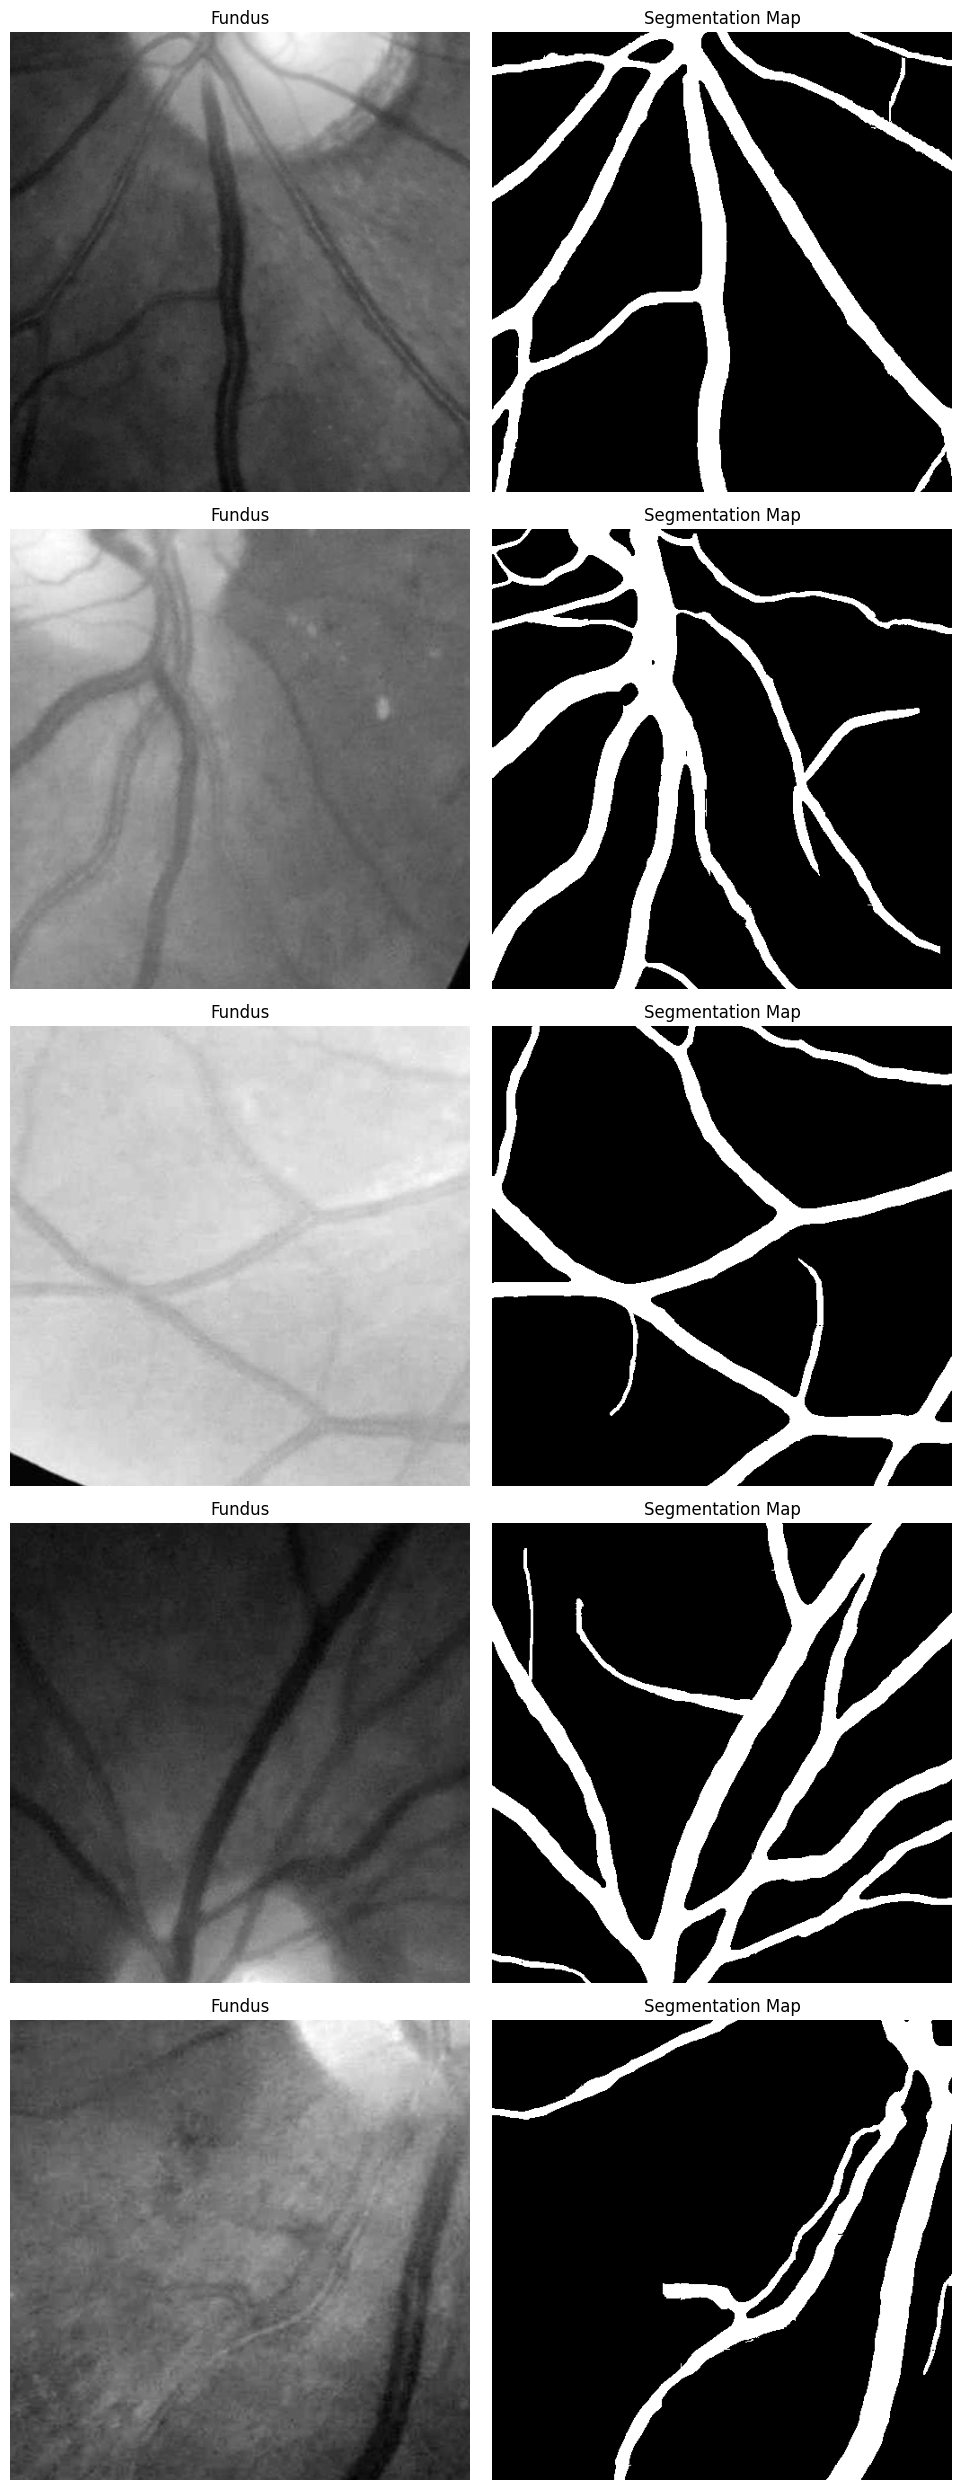

In [3]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=5):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 5))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))  # Convert from PyTorch tensor format and channel first to channel last
        lbl = labels[i].numpy().squeeze()            # Remove extra dimensions
        
        if num_images == 1:
            ax_img = axs[0]
            ax_lbl = axs[1]
        else:
            ax_img = axs[i, 0]
            ax_lbl = axs[i, 1]
        
        ax_img.imshow(img, cmap='gray')
        ax_img.set_title('Fundus')
        ax_img.axis('off')
        
        ax_lbl.imshow(lbl, cmap='gray')
        ax_lbl.set_title('Segmentation Map')
        ax_lbl.axis('off')

    plt.tight_layout()
    plt.show()

show_images(*zip(*[random_crop_dataset[i] for i in range(5)]))

# Training

In [2]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch
from segmentation_util import model_pipeline, build_criterion, build_optimizer, build_segmentation_model
import matplotlib.pyplot as plt

# Define Hyperparameters
encoder = 'timm-regnety_320'
architecture = 'UnetPlusPlus'
learning_rate = 0.012003441858688528
epochs = 10
loss = 'BCE'
optimizer = 'Adam'

config = {
    'model': '{architecture}-{encoder}-{width}x{height}-augmented-with-random-crops-single-channel'.format(architecture=architecture, width=width, height=height, encoder=encoder),
    'learning_rate': learning_rate,
    'epochs': 10,
    'batch_size': trainloader.batch_size,
    'optimizer': optimizer,
    'criterion': loss,
    'encoder': encoder,
    'architecture': architecture,
}

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = build_segmentation_model(encoder, architecture=config['architecture'], device=device)
optimizer = build_optimizer(model, learning_rate=config['learning_rate'], optimizer=config['optimizer'])
criterion = build_criterion(config['criterion'])

model, train_losses, val_losses = model_pipeline(model, trainloader=trainloader, 
                                                 validationloader=validationloader, 
                                                 testloader=testloader, 
                                                 criterion=criterion, 
                                                 optimizer=optimizer,
                                                 project='fundus-segmentation',
                                                 model_name=config['model'],
                                                 epochs=config['epochs'],
                                                 device=device, 
                                                 config=config)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Epoch 1, Batch 10, Loss: 0.4198


In [ ]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet('resnet152', in_channels=1, classes=1)
model.load_state_dict(torch.load('./models/Unet-resnet152-512x512-augmented-with-random-crops_epoch10.pth'))

# Evaluation

In [ ]:
from segmentation_util import evaluate_model, predict
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_overlay(model, data, device):
    prediction = predict(model, data[0], device)
    image = data[1].cpu().numpy().squeeze()
    image = np.stack([image, image, image], axis=-1)
    overlay = np.zeros_like(image)
    overlay[prediction.cpu().numpy().squeeze(0) == 1] = [0, 255, 0]
    combined = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(combined, cmap='gray')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
show_overlay(model, testset[0], device)
# show_images(*zip(*[train_dataset[i] for i in range(5)]))

# Hyperparameter Tuning

In [1]:
import wandb
import torch
from segmentation_util import train_sweep, build_dataloaders

sweep_config = {
    'name': 'Fundus-Segmentation-Sweep',
    'method': 'bayes',
    'parameters': {
        'encoder': {
            'values': ['resnet152', 'resnext101_32x8d', 'timm-resnest269e', 'timm-regnetx_320', 'timm-regnety_320', 'senet154']
        },
        'learning_rate': {
            "min": 0.00001, 
            "max": 0.1
        },
        'epochs': {
            'value': 10
        },
        'loss': {
            'values': ['Dice', 'BCE']
        },
        'optimizer': {
            'values': ['Adam', 'SGD']
        },
        'batch_size': {
            'value': 8
        },
        'proportion_augmented_data': {
            'values': [0.1, 0.2, 0.3]
        },
        'architecture': {
            'values': ['Unet', 'UnetPlusPlus']
        }
    },
    'metric': {
        'name': 'dice_score',
        'goal': 'maximize'
    }
}
sweep_config['parameters']['device'] = {'value':'cuda:0' if torch.cuda.is_available() else 'cpu'}
sweep_id = wandb.sweep(sweep_config, project='fundus-segmentation')
wandb.agent(sweep_id, function=train_sweep, count=10)

Number of samples in the training set: 534, validation set: 60
Number of samples in the test set: 200
